In [3]:
import numpy as np
import scipy as sci
from typing import Iterator
import matplotlib.pyplot as plt

In [102]:
## simulate a mixture of Gaussian with two components
## we specifically simulate the data this way:
## the first 10% of the data are sampled from the first mixture
## the second 10% of the data are sampled from the second mixture
## the third 10% of the data are sampled from the first mixture
## the fourth 10% of the data are sampled from the second mixture, etc. 
def generate_mixture_of_gaussian(means, stds, stream_size, ratio=0.1):
    data = []
    block_size = int(stream_size * ratio)
    n_blocks = stream_size // block_size
    for i in range(n_blocks):
        idx = i % 2
        data.append(np.random.normal(means[idx], stds[idx], block_size))
    data = np.concatenate(data)
    return data

In [38]:
## define a class that uses reservoir sampling to 
## estimate the mean
class ReservoirSamplingEst:
    def __init__(self, k=20):
        # k (int) the size of the reservoir
        self.k = k
        self.reservoir = []
        self.est_mean = []
        
    def fit(self, data_stream):
        ## reservoir sampling
        for i, dp in enumerate(data_stream):
            if i < self.k:
                self.reservoir.append(dp)
            else:
                ## pick a data point uniformly at random from the reservoir
                idx = np.random.randint(0, self.k)
                ## replace the picked data point with prob. (k/i)
                if np.random.rand() < (self.k / i):
                    self.reservoir[idx] = dp
            
                ## estimate the mean
                est_m = np.mean(self.reservoir)
                self.est_mean.append(est_m)

In [71]:
## a simple baseline method 
## intuitively, we keep a local buffer of size k without any fancy sampling
## as data comes in we store them in the buffer as long as the size is within k
## we drop the earliest data point to maintain the size 
from collections import deque
class SlidingWindowBaseline:
    def __init__(self, k=20):
        self.k = k
        self.buffer = deque()
        self.est_mean = []

    def fit(self, data_stream):
        for i, dp in enumerate(data_stream):
            if i < self.k:
                self.buffer.append(dp)
            else:
                self.buffer.popleft()
                self.buffer.append(dp)

                ## estimate the mean based on the data in the buffer
                est_m = np.mean(self.buffer)
                self.est_mean.append(est_m)

In [103]:
## simulate a data stream with 100k data points
mu_1 = 5.5
sigma_1 = 3
mu_2 = 0.0
sigma_2 = 1
N = 100000
data_stream = generate_mixture_of_gaussian([mu_1, mu_2], [sigma_1, sigma_2], N)

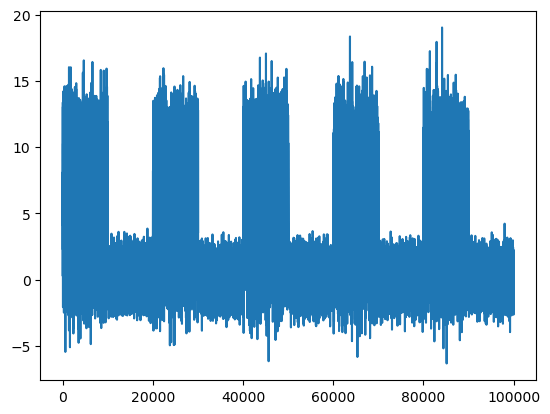

In [104]:
plt.plot(data_stream)

In [113]:
## experiment with the size of k
RS_200 = ReservoirSamplingEst(k=200)
RS_500 = ReservoirSamplingEst(k=500)
RS_1000 = ReservoirSamplingEst(k=1000)


baseline_200 = SlidingWindowBaseline(k=200)
baseline_500 = SlidingWindowBaseline(k=500)
baseline_1000 = SlidingWindowBaseline(k=1000)


RS_200.fit(data_stream)
RS_500.fit(data_stream)
RS_1000.fit(data_stream)

baseline_200.fit(data_stream)
baseline_500.fit(data_stream)
baseline_1000.fit(data_stream)

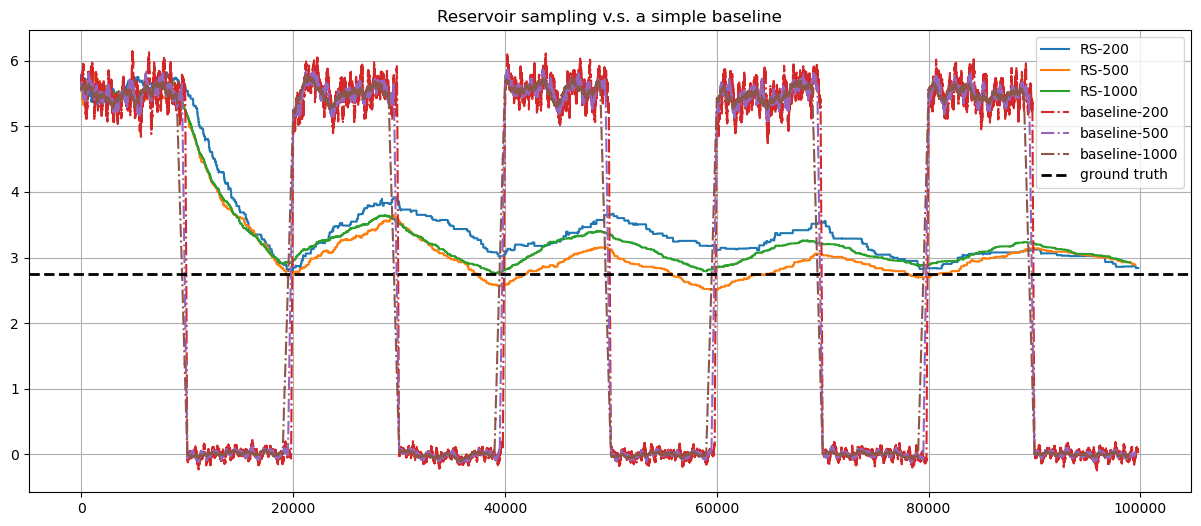

In [116]:
plt.figure(figsize=(15, 6))

plt.plot(RS_200.est_mean, label='RS-200')
plt.plot(RS_500.est_mean, label='RS-500')
plt.plot(RS_1000.est_mean, label='RS-1000')

plt.plot(baseline_200.est_mean, label='baseline-200', linestyle='-.')
plt.plot(baseline_500.est_mean, label='baseline-500', linestyle='-.')
plt.plot(baseline_1000.est_mean, label='baseline-1000', linestyle='-.')

true_mean = np.mean(data_stream)
plt.title("Reservoir sampling v.s. a simple baseline")
plt.axhline(y=true_mean, color='k', linestyle='--', linewidth=2, label='ground truth')
plt.grid(True)
plt.legend()

The data is alternately sampled from the two mixtures, causing the sliding window to bias towards the most recent data. This results in a highly fluctuating estimated mean. In contrast, Reservoir Sampling ensures that the data points in the reservoir are a uniformly sampled subset from the entire data stream, making the estimated mean less sensitive to alternation.